# Speech Understanding 
# Lecture 8: Fourier Transform



### Mark Hasegawa-Johnson, KCGI

Last time we learned how to create pure tones.   This time, we will learn how to create and analyze chords, each composed of three pure tones together.

1. [The orthogonality principle](#section1)
1. [Musical Chords](#section2)
1. [The Discrete Cosine Transform (DCT)](#section3)
1. [The Discrete Fourier Transform (DFT)](#section4)
1. [homework](#homework)

<a id="section1"></a>

## 1 The orthogonality principle

The **orthogonality principle** is:

* The **average value** of
* the **product** of
* two **pure tones** with **different frequencies**
* is **zero**.

In equation form, the orthogonality principle says that, if $k\ne m$ and they are both integers, then:

$$0 = \sum_{n=0}^{N-1} \cos\left(\frac{2\pi k n}{N}\right)\cos\left(\frac{2\pi mn}{N}\right)$$

Let's see an example.  Let's set $k=3$, $m=4$, and $N=24$:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The total of x*y is -1.8318679906315083e-15 
---------------------------------------------


Text(0.5, 1.0, 'cos(6πn/20)*cos(8πn/20) has a total value of -0.000')

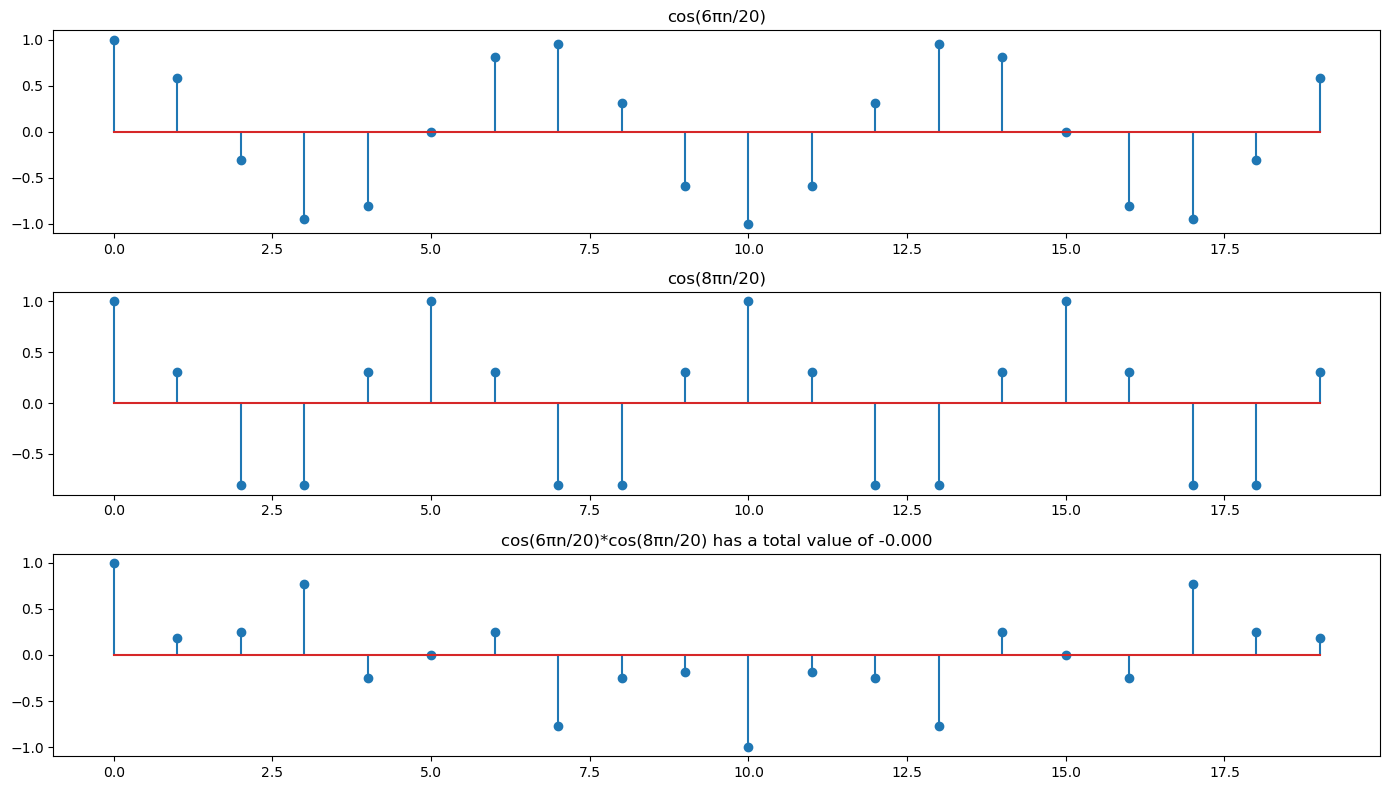

In [2]:
k = 3
m = 4
N = 20
n = np.arange(N)

x = np.cos(2*np.pi*k*n/N)
y = np.cos(2*np.pi*m*n/N)

total = sum(x*y)
print('The total of x*y is',total,'\n---------------------------------------------')

fig = plt.figure(figsize=(14,8),layout='tight')
subfigs = fig.subplots(3,1)
subfigs[0].stem(x)
subfigs[0].set_title('cos(6πn/20)')
subfigs[1].stem(y)
subfigs[1].set_title('cos(8πn/20)')
subfigs[2].stem(x*y)
subfigs[2].set_title('cos(6πn/20)*cos(8πn/20) has a total value of %3.3f'%(total))

You might think: OK, but why is that interesting?

The reason it's interesting is that there is **just one exception:** the case when $k=m$.

That's obvious when you think about it, because $x[n]^2 > 0$ for any $x[n]\ne 0$, so $\sum_n x^2[n] > 0$ for any nonzero pure tone.  Let's see an example: 

The total of x*y is 9.999999999999998 
---------------------------------------------


Text(0.5, 1.0, 'cos(6πn/20)*cos(6πn/20) has a total value of 10.000')

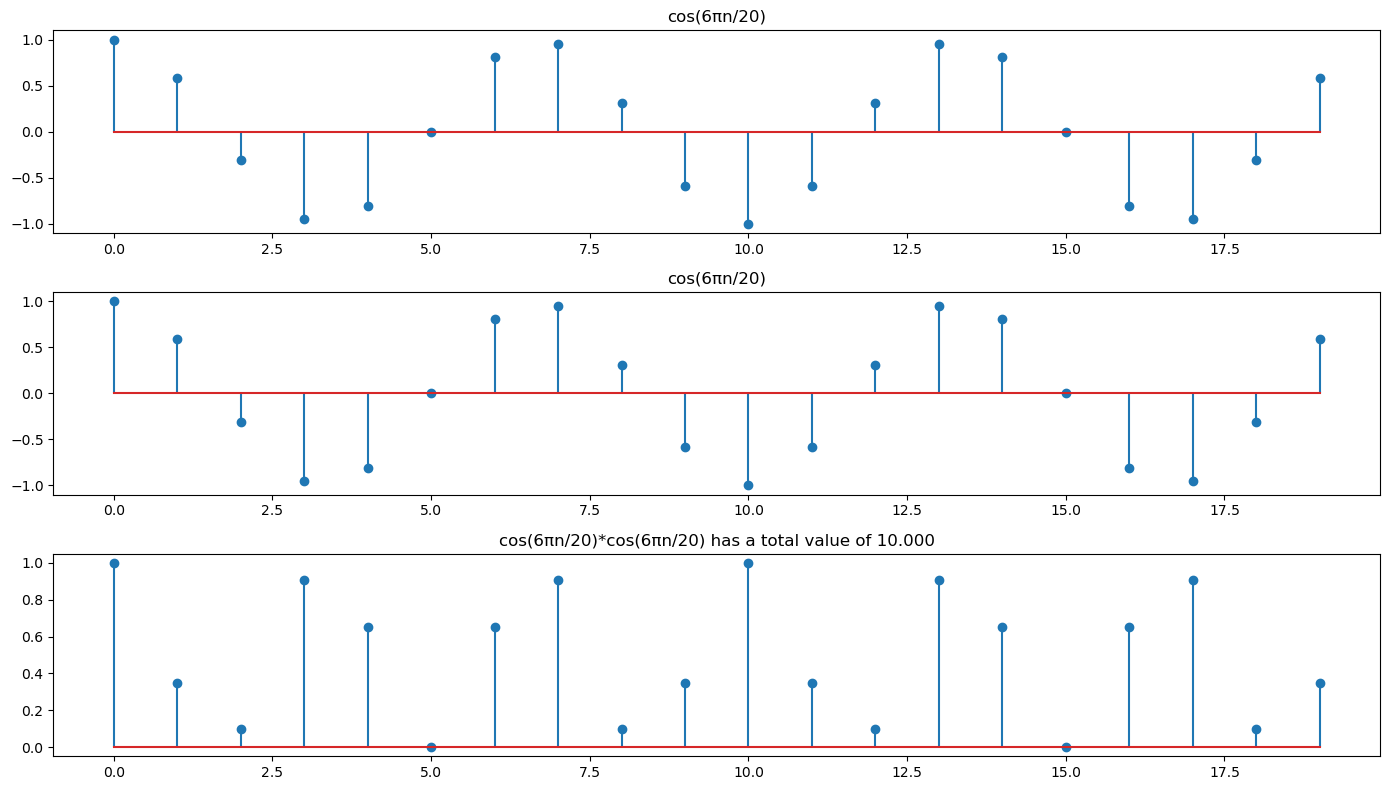

In [3]:
k = 3
m = 3
N = 20
n = np.arange(N)

x = np.cos(2*np.pi*k*n/N)
y = np.cos(2*np.pi*m*n/N)

total = sum(x*y)
print('The total of x*y is',total,'\n---------------------------------------------')

fig = plt.figure(figsize=(14,8),layout='tight')
subfigs = fig.subplots(3,1)
subfigs[0].stem(x)
subfigs[0].set_title('cos(6πn/20)')
subfigs[1].stem(y)
subfigs[1].set_title('cos(6πn/20)')
subfigs[2].stem(x*y)
subfigs[2].set_title('cos(6πn/20)*cos(6πn/20) has a total value of %3.3f'%(total))
    

The general statement of the orthogonality principle, for cosines, is:

$$\sum_{n=0}^{N-1} \cos\left(\frac{2\pi k n}{N}\right)\cos\left(\frac{2\pi m n}{N}\right)
=\left\{\begin{array}{cc}N/2 & k=m~\text{or}~k=N-m\\0&\text{otherwise}\end{array}\right.$$

The possibility that $k=N-m$ comes from aliasing.

<a id="section2"></a>

## 2. Musical Chords

A musical chord is a combination of pure tones that sound good together.  For example,

### Major Chord

A major chord is a root tone, a major third tone (4 semitones above root), and a major fifth tone (7 semitones above root), thus:

$$x[n]=\cos\left(\omega_0 n\right) + \cos\left(G^4\omega_0n\right)+\cos\left(G^7\omega_0n\right)$$
where $G$ is the semitone scaling constant,
$$G=2^{1/12}$$

### Minor Chord

A minor chord is a root tone, a minor third tone (3 semitones above root), and a major fifth tone (7 semitones above root), thus:

$$x[n]=\cos\left(\omega_0 n\right) + \cos\left(G^3\omega_0n\right)+\cos\left(G^7\omega_0n\right)$$


Let's do an example by constructing A-major and A-minor chords.  Remember A440 has a frequency of $\omega_0=\frac{2\pi 440}{F_s}$ radians/sample, thus

In [4]:
f0 = 440
Fs = 8000
omega0 = 2*np.pi*f0/Fs
n = np.arange(2*Fs)
G = np.power(2,1/12)

major_chord = np.cos(omega0*n)+np.cos(np.power(G,4)*omega0*n)+np.cos(np.power(G,7)*omega0*n)
import IPython.display
IPython.display.Audio(data=major_chord, rate=Fs)

In [5]:
minor_chord = np.cos(omega0*n)+np.cos(np.power(G,3)*omega0*n)+np.cos(np.power(G,7)*omega0*n)
IPython.display.Audio(data=minor_chord, rate=Fs)

Suppose that you were given the sound file `minor_chord`, and you wanted to figure out what cosines were used to make it.  One thing you could try would be to plot about 1/20 of a second, so see what it looks like:

In [ ]:
N = int(Fs/20)

fig = plt.figure(figsize=(14,4),layout='tight')
subfig = fig.subplots(1,1)
subfig.plot(minor_chord[:N])

Well, plotting it doesn't seem to help very much!

Here's a better solution: in order to figure out which pure tones are part of this minor chord, we can use the **orthogonality principle**.


<a id="section3"></a>

## 3. The Discrete Cosine Transform (DCT)

The DCT uses the orthogonality principle to find out which pure tones were used to make a chord.  Remember that the orthogonality principle for cosines is:

$$\sum_{n=0}^{N-1} \cos\left(\frac{2\pi k n}{N}\right)\cos\left(\frac{2\pi m n}{N}\right)
=\left\{\begin{array}{cc}N/2 & k=m~\text{or}~k=N-m\\0&\text{otherwise}\end{array}\right.$$

Let's create a matrix $W$ whose $(k_1,n)^{\text{th}}$ element is $w[k,n]=\cos\left(\frac{2\pi kn}{N}\right)$, and a vector $x$ whose $n^{\text{th}}$ element is $x[n]=\cos\left(\frac{2\pi mn}{N}\right)$.  Then:

$$\sum_{n=0}^{N-1} w[k,n]x[n]
=\left\{\begin{array}{cc}N/2 & k=m~\text{or}~k=N-m\\0&\text{otherwise}\end{array}\right.$$

Notice that the summation, there, is the formula for a matrix multiplication!  We can implement it as:
$$X=\left[\begin{array}{c}X[0]\\\vdots\\X[k]\\\vdots\\X[N-1]\end{array}\right] =
\left[\begin{array}{ccccc}w[0,0]&\cdots&w[0,n]&\cdots&w[0,N-1]\\
\vdots&\ddots&\vdots&\ddots&\vdots\\
w[k,0]&\cdots&w[k,n]&\cdots&w[k,N-1]\\
\vdots&\ddots&\vdots&\ddots&\vdots\\
w[N-1,0]&\cdots&w[N-1,n]&\cdots&w[N-1,N-1]\end{array}\right]
\left[\begin{array}{c}x[0]\\\vdots\\x[n]\\\vdots\\x[N-1]\end{array}\right]=Wx$$

And the result will be
$$X[k]=\left\{\begin{array}{cc} N/2 & k=m~\text{or}~k=N-m\\0&\mbox{otherwise}\end{array}\right.$$

In [ ]:
N = 20
m = 4
n = np.arange(N)

x = np.cos(2*np.pi*m*n/N)

W = np.zeros((N,N))
for k in range(N):
    for n in range(N):
        W[k,n] = np.cos(2*np.pi*k*n/N)
    
X = np.matmul(W,x)

fig = plt.figure(figsize=(14,4))
subfig = fig.subplots(1,1)
subfig.stem(X)
subfig.set_title('DCT{cos(8πn/20)}=20/2=10 at k=4 and at k=20-4, DCT{cos(8πn/20)}=0 everywhere else')

We can use this to find out what pure tones are part of the minor chord!   Let's create a giant $W$ matrix, with 400 rows and 400 columns, and multiply it times the first 400 samples of `minor_chord`:

In [ ]:
N = 400
W = np.zeros((N,N))
for k in range(N):
    for n in range(N):
        W[k,n] = np.cos(2*np.pi*k*n/N)
        
X = np.matmul(W,minor_chord[:N])

fig=plt.figure(figsize=(14,4))
subfig=fig.subplots(1,1)
subfig.stem(X)


Let's ignore the aliased tones, and zoom in on the three peaks that correspond to the three notes of the chord:

In [ ]:
fig=plt.figure(figsize=(14,4))
subfig=fig.subplots(1,1)
subfig.stem(X)
subfig.set_xlim(0,50)

We can see that the three pure tones in this chord are at:

* $k=22$
* $k=25$
* $k=33$

But what frequencies are those?  Remember that the $k^{\text{th}}$ row of the $W$ matrix is $\cos(2\pi kn/N)$.  We can convert back to frequencies if we remember that, for $\cos(\omega n)$,

$$\omega = \frac{2\pi f}{F_s}$$
So let's set
$$\frac{2\pi f}{F_s} = \frac{2\pi k}{N}$$
... and solving, we get:
$$f=\left(\frac{k}{N}\right)F_s$$
In other words, find the fraction $k/N$: $f$ is that fraction of $F_s$.  Let's use such an $f$ scale as the X-axis labels in our DCT plot:


In [ ]:
k = np.arange(N)
f = (k/N)*Fs

fig=plt.figure(figsize=(14,4))
subfig=fig.subplots(1,1)
subfig.stem(f,X)
subfig.set_xlim(350,750)
subfig.set_xlabel('Frequency f (in Hertz)')
subfig.set_title('These three pure tones are an A-Minor Chord')

We can see that the three pure tones in an A-minor chord are:

* $f=440$ -- the root A tone
* $f=520$ -- the minor third (C)
* $f=660$ -- the major fifth (E)

<a id="section4"></a>

## 4.  Discrete Fourier Transform

What happens if the minor third is made of **sines** instead of **cosines**?  Let's find out:

In [ ]:
f0 = 440
Fs = 8000
omega0 = 2*np.pi*f0/Fs
n = np.arange(2*Fs)
G = np.power(2,1/12)

sine_minor_chord = np.sin(omega0*n)+np.sin(np.power(G,3)*omega0*n)+np.sin(np.power(G,7)*omega0*n)
IPython.display.Audio(data=minor_chord, rate=Fs)

It sounds **exactly the same,** because **the human ear can't hear phase.**

But will a $W$ matrix composed of cosines be able to analyze this?  Let's try it:

In [ ]:
N = 400
W = np.zeros((N,N))
for k in range(N):
    for n in range(N):
        W[k,n] = np.cos(2*np.pi*k*n/N)

X_cosines = np.matmul(W,minor_chord[:N])
X_sines = np.matmul(W,sine_minor_chord[:N])

k = np.arange(N)
f = (k/N)*Fs

fig=plt.figure(figsize=(14,4))
subfig=fig.subplots(1,1)
subfig.stem(f,X_cosines,'b')
subfig.stem(f,X_sines,'r')
subfig.set_xlim(350,750)
subfig.set_title('Cosine or Sine detected by Cosines',fontsize=24)
subfig.legend(['cosine minor chord','sine minor chord'],fontsize=18)

Well, that didn't work well.
* The tone at $f=520$ was only halfway detected.
* The tone at $f=440$ wasn't detected at all.

The problem, of course, is that, to **detect a sine wave,** you need to **use a sine wave**.

In [ ]:
N = 400
W = np.zeros((N,N))
for k in range(N):
    for n in range(N):
        W[k,n] = np.sin(2*np.pi*k*n/N)   ##### sine instead of cosine
        
X_cosines = np.matmul(W,minor_chord[:N])
X_sines = np.matmul(W,sine_minor_chord[:N])

k = np.arange(N)
f = (k/N)*Fs

fig=plt.figure(figsize=(14,4))
subfig=fig.subplots(1,1)
subfig.stem(f,X_cosines,'b')
subfig.stem(f,X_sines,'r')
subfig.set_xlim(350,750)
subfig.set_title('Cosine or Sine detected by Sines',fontsize=24)
subfig.legend(['cosine minor chord','sine minor chord'],fontsize=18)

So we know that 
* If $W$ is made of cosines, then it can analyze a minor chord made of cosines
* If $W$ is made of sines, then it can analyze a minor chord made of sines

How can we get both?  Here's the trick: we can use **complex numbers**!  Define imaginary numbers using
$$j=\sqrt{-1}$$
Then set the matrix $W$ to have elements like this:
$$w[k,n]=\cos\left(\frac{2\pi kn}{N}\right)-j\sin\left(\frac{2\pi kn}{N}\right)$$

Now, if we compute
$$X[k] = \sum_{n=0}^{N-1} w[k,n] x[n]$$
we will find that
$$X[k]=\left\{\begin{array}{ll}
N/2 & x[n]=\cos(2\pi kn/N)\\
jN/2 & x[n]=\sin(2\pi kn/N)\\
0 & \mbox{otherwise}\end{array}\right.$$

So we can detect both **cosines and sines** by computing $|X[k]|$ (that means "the absolute value of $X[k]$", and it is computed as:

$$|X[k]|=\sqrt{\text{real}\left\{X[k]\right\}^2+\text{imaginary}\left\{X[k]\right\}^2}$$
or we can use the numpy function `np.abs(X)`.

In [ ]:
j = 0+1j  ### This is how you write the imaginary number "j" in numpy
 
N = 400
W = np.zeros((N,N), dtype='complex')   # We have to specify that W is complex, too!!
for k in range(N):
    for n in range(N):
        W[k,n] = np.cos(2*np.pi*k*n/N) - j*np.sin(2*np.pi*k*n/N)   ##### cosine - j * sine
        
X_cosines = np.matmul(W,minor_chord[:N])
X_sines = np.matmul(W,sine_minor_chord[:N])

k = np.arange(N)
f = (k/N)*Fs

fig=plt.figure(figsize=(14,6), layout='tight')
subfig=fig.subplots(2,1)
subfig[0].stem(f,np.abs(X_cosines),'b')  ## notice: np.abs takes absolute value
subfig[0].set_title('Cosines detected by the Discrete Fourier Transform',fontsize=18)
subfig[0].set_xlim(350,750)
subfig[1].stem(f,np.abs(X_sines),'r')   ## notice: np.abs takes absolute value
subfig[1].set_title('Sines detected by the Discrete Fourier Transform',fontsize=18)
subfig[1].set_xlim(350,750)


This kind of frequency analysis is the basis of all audio analysis.  It's so important that numpy provides a special function for it: `np.fft.fft` (fft means **fast Fourier transform**).

In [ ]:
        
X_cosines = np.fft.fft(minor_chord[:N])
X_sines = np.fft.fft(sine_minor_chord[:N])

k = np.arange(N)
f = (k/N)*Fs

fig=plt.figure(figsize=(14,6), layout='tight')
subfig=fig.subplots(2,1)
subfig[0].stem(f,np.abs(X_cosines),'b')  ## notice: np.abs takes absolute value
subfig[0].set_title('Cosines detected by the Fast Fourier Transform',fontsize=18)
subfig[0].set_xlim(350,750)
subfig[1].stem(f,np.abs(X_sines),'r')   ## notice: np.abs takes absolute value
subfig[1].set_title('Sines detected by the Fast Fourier Transform',fontsize=18)
subfig[1].set_xlim(350,750)


<a id="homework"></a>

## Homework 8

The homework this week has just one function: `W = homework8.dft_matrix(N)`.   Given a scalar integer $N$, this function should return the DFT transform matrix $W$ whose $(k,n)^{\text{th}}$ element is given by 

$$w[k,n] = \cos\left(\frac{2\pi kn}{N}\right) - j\sin\left(\frac{2\pi kn}{N}\right)$$

In [6]:
import homework8, importlib
importlib.reload(homework8)
help(homework8.dft_matrix)

Help on function dft_matrix in module homework8:

dft_matrix(N)
    Create a DFT transform matrix, W, of size N.
    
    @param:
    N (scalar): number of columns in the transform matrix
    
    @result:
    W (NxN array): a matrix of dtype='complex' whose (k,n)^th element is:
           W[k,n] = cos(2*np.pi*k*n/N) - j*sin(2*np.pi*k*n/N)



You can test your code using a simple cosine, with an arbitrary phase.  For example,

Text(0.5, 1.0, 'cos(6 pi n/30+pi/4)')

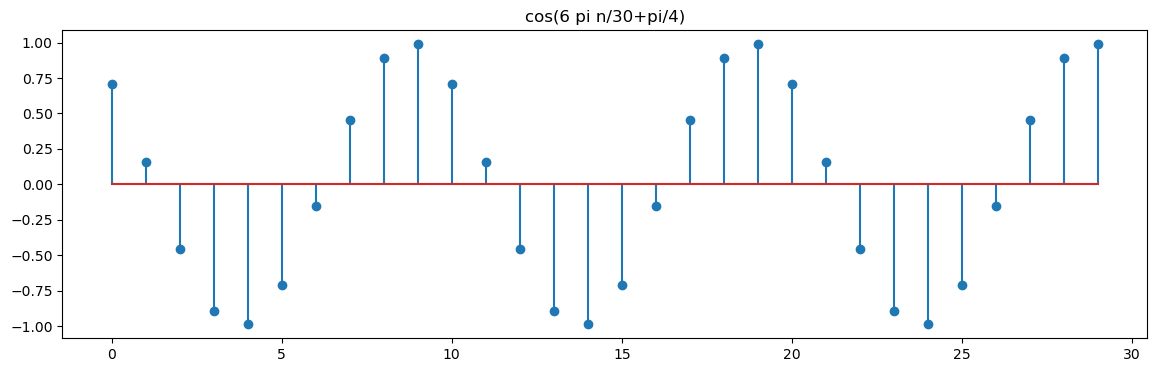

In [7]:
N = 30
n = np.arange(N)
x = np.cos(2*np.pi*3*n/N + np.pi/4)
fig = plt.figure(figsize=(14,4))
subfig = fig.subplots(1,1)
subfig.stem(n,x)
subfig.set_title('cos(6 pi n/30+pi/4)')

When your function `homework8.dft_matrix` works correctly, the following two plots should be identical:

True


Text(0.5, 1.0, 'Fourier transform of cos(6 pi n/30+pi/4) computed with homework6.dft_matrix')

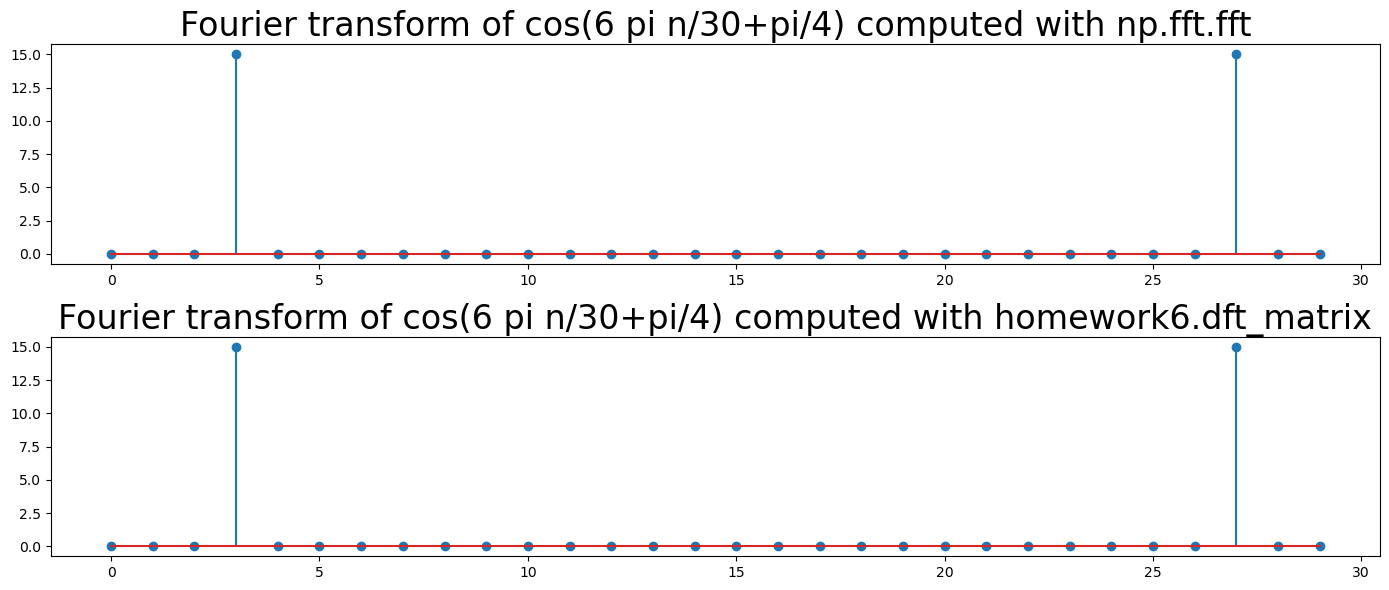

In [8]:
import homework8, importlib
importlib.reload(homework8)
W = homework8.dft_matrix(N)
print(W.dtype == complex)

fig = plt.figure(figsize=(14,6),layout='tight')
subfig = fig.subplots(2,1)

subfig[0].stem(np.abs(np.fft.fft(x)))
subfig[0].set_title('Fourier transform of cos(6 pi n/30+pi/4) computed with np.fft.fft',fontsize=24)

subfig[1].stem(np.abs(W@x))
subfig[1].set_title('Fourier transform of cos(6 pi n/30+pi/4) computed with homework6.dft_matrix',fontsize=24)

### Receiving your grade

In order to receive a grade for your homework, you need to:

1. Run the following code block on your machine.  The result may list some errors, and then in the very last line, it will show a score.  That score (between 0% and 100%) is the grade you have earned so far.  If you want to earn a higher grade, please continue editing `homework3.py`, and then run this code block again.
1. When you are happy with your score (e.g., when it reaches 100%), choose `File` $\Rightarrow$ `Save and Checkpoint`.  Then use `GitHub Desktop` to commit and push your changes.
1. Make sure that the 100% shows on your github repo on github.com.  If it doesn't, you will not receive credit.

In [9]:
import importlib, grade
importlib.reload(grade)

....
----------------------------------------------------------------------
Ran 4 tests in 0.019s

OK
....
----------------------------------------------------------------------
Ran 4 tests in 0.013s

OK


4 successes out of 4 tests run
Score: 100%
4 successes out of 4 tests run
Score: 100%


<module 'grade' from 'C:\\Users\\12707\\Documents\\GitHub\\intro_speech_understanding\\2023_fall\\lec08\\grade.py'>